This notebook demonstrates how `dem-stitcher` uses the Copernicus Glo-90 DEM to fill in Glo-30 missing areas over the countries Azerbaijan and Armenia as documented [here](https://github.com/ACCESS-Cloud-Based-InSAR/DockerizedTopsApp/issues/67).

This could be used to combine different DEMs so we are sharing it. At the end of the notebook, we demonstrate the new API.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from dem_stitcher.datasets import DATASETS
from dem_stitcher.stitcher import stitch_dem, get_dem_tile_extents
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.crs import CRS
from shapely.geometry import box
from rasterio.plot import show
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.enums import Resampling

DATASETS

['srtm_v3', 'nasadem', 'glo_90_missing', 'glo_30', '3dep', 'glo_90', 'ned1']

In [5]:
# over Eastern Armenia and Western Turkey
bounds = [42, 39, 44, 41]

In [6]:
%%time

X_glo_30, p_30 = stitch_dem(bounds,
                            dem_name='glo_30',
                            dst_ellipsoidal_height=True,
                            fill_in_glo_30=False)

Reading glo_30 Datasets: 100%|█| 11/11 [00:15<00:00,  1.43s/


CPU times: user 9.31 s, sys: 4.25 s, total: 13.6 s
Wall time: 1min 54s


(38.0, 42.0)

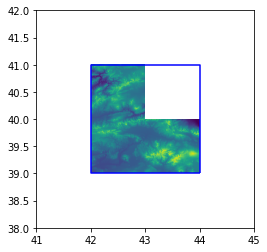

In [7]:
fig, ax = plt.subplots()

df_box = gpd.GeoDataFrame(geometry=[box(*bounds)],
                          crs=CRS.from_epsg(4326))

df_box.boundary.plot(ax=ax, color='blue')
show(X_glo_30, transform=p_30['transform'], ax=ax)

ax.set_xlim(bounds[0] - 1, bounds[2] +1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

# Does extent intersect missing tiles?

We now have `glo_90_missing` as a DEM dataset to obtain the `glo_30` tiles that have representatives in `glo_90`. See `notebooks/organize_tile_data/1_Missing_glo-30_tiles.ipynb` how this geojson was generated.

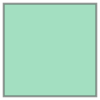

In [8]:
extent_geo = df_box.geometry[0]
extent_geo

In [9]:
df_missing = get_dem_tile_extents('glo_90_missing')
df_missing.shape

(25, 4)

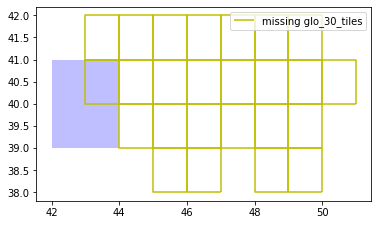

In [10]:
fig, ax = plt.subplots()

df_missing.boundary.plot(ax=ax, color='y', label='missing glo_30_tiles')
df_box.plot(ax=ax, color='blue', alpha=.25)
plt.legend()

In [11]:
df_missing.intersects(extent_geo).sum()

5

There are 5 extents that intersect (boundaries count).

# Get Missing Tiles

In [12]:
%%time

X_glo_90_missing, p_90 = stitch_dem(bounds,
                                    dem_name='glo_90_missing',
                                    dst_ellipsoidal_height=True)

Reading glo_90_missing Datasets: 100%|█| 5/5 [00:07<00:00,  


CPU times: user 913 ms, sys: 424 ms, total: 1.34 s
Wall time: 16.6 s


(38.0, 42.0)

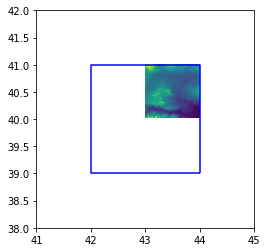

In [13]:
fig, ax = plt.subplots()

df_box.boundary.plot(ax=ax, color='blue')
show(X_glo_90_missing, transform=p_90['transform'], ax=ax)

ax.set_xlim(bounds[0] - 1, bounds[2] +1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

# Merge 30 and 90

In [14]:
with MemoryFile() as memfile_90:
    dataset_90 = memfile_90.open(**p_90)
    dataset_90.write(X_glo_90_missing,1)
        
    with MemoryFile() as memfile_30:
        dataset_30 = memfile_30.open(**p_30)
        dataset_30.write(X_glo_30, 1)
        
        merged_arr, merged_trans = merge([dataset_30, dataset_90],
                                         resampling=Resampling['bilinear'],
                                         method='first',
                                         )
        merged_arr = merged_arr[0, ...]

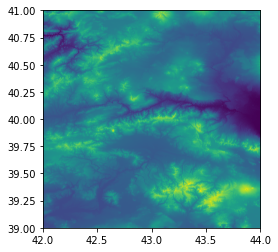

<AxesSubplot:>

In [15]:
show(merged_arr, transform=merged_trans)

To save this.

In [16]:
# p_30_merged = p_30.copy()
# p_30_merged['transform'] = merged_trans
# p_30_merged['width'] = merged_arr.shape[1]
# p_30_merged['height'] = merged_arr.shape[0]

# with rasterio.open('glo_30_filled_by_90.tif', 'w', **p_30_merged) as ds:
#     ds.write(merged_arr, 1)

# Using `dem-stitcher`

See `tests/test_missing.py` for more examples how this notebook was distilled to ensure correctness.

Reading glo_30 Datasets: 100%|█| 11/11 [00:03<00:00,  3.06it
Reading glo_90_missing Datasets: 100%|█| 5/5 [00:01<00:00,  


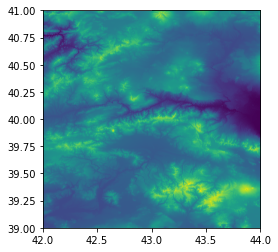

<AxesSubplot:>

In [17]:
extent = [42.95, 40.45, 43.05, 40.55]

dst_area_or_point = 'Point'
dst_ellipsoidal_height = False
dem_name = 'glo_30'

X_filled, p_filled = stitch_dem(bounds,
                                dem_name=dem_name,
                                dst_ellipsoidal_height=dst_ellipsoidal_height,
                                dst_area_or_point=dst_area_or_point,
                                fill_in_glo_30=True)

show(X_filled, transform=p_filled['transform'])